In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)

# Suppress warnings
import warnings

warnings.filterwarnings("ignore")

In [ ]:
# Load the Dataset
try:
    df = pd.read_csv("data/loan_data_raw.csv")
    print("Data loaded successfully.")
except FileNotFoundError:
    print("Error: loan_data.csv not found. Please download the dataset from Kaggle.")


Data loaded successfully.


In [2]:
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   loan_id                    4269 non-null   int64 
 1    no_of_dependents          4269 non-null   int64 
 2    education                 4269 non-null   object
 3    self_employed             4269 non-null   object
 4    income_annum              4269 non-null   int64 
 5    loan_amount               4269 non-null   int64 
 6    loan_term                 4269 non-null   int64 
 7    cibil_score               4269 non-null   int64 
 8    residential_assets_value  4269 non-null   int64 
 9    commercial_assets_value   4269 non-null   int64 
 10   luxury_assets_value       4269 non-null   int64 
 11   bank_asset_value          4269 non-null   int64 
 12   loan_status               4269 non-null   object
dtypes: int64(10), object(3)
memory usage: 433.7+ KB
None
   loan_id

## Data cleaning/formatting

In [ ]:
print(df["loan_status"].unique())

[' Approved' ' Rejected']


In [ ]:
# Clean column names
df.columns = df.columns.str.strip()

# Clean whitespace from string columns
for col in ("loan_status", "education", "self_employed"):
    df[col] = df[col].astype(str).str.strip()

# Drop the non-predictive Loan_ID column
df = df.drop("loan_id", axis=1, errors="ignore")

# Convert target variable to binary (1 and 0)
df["loan_status"] = df["loan_status"].replace({"Approved": 1, "Rejected": 0})

X = df.copy().drop("loan_status", axis=1)
y = df.copy()["loan_status"]

# Target class ratio
print(y.value_counts(normalize=True))

# Split data into training and test sets (70/30)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
print(f"\nTraining samples: {len(X_train)} \nTest samples: {len(X_test)}")

# Define Feature Types for Preprocessing
categorical_features = X_train.select_dtypes(include=["object"]).columns.tolist()
numeric_features = X_train.select_dtypes(include=np.number).columns.tolist()


loan_status
1    0.62216
0    0.37784
Name: proportion, dtype: float64

Training samples: 2988 
Test samples: 1281


# Data exploration

In [105]:
# Descriptive statistics of numeric features
X_train[numeric_features].describe().T

,count,mean,std,min,25%,50%,75%,max
no_of_dependents,2988.0,2.499331e+00,1.691963e+00,0.0,1.00,3.0,4.00,5.0
income_annum,2988.0,5.060509e+06,2.812776e+06,200000.0,2600000.00,5100000.0,7500000.00,9900000.0
loan_amount,2988.0,1.506553e+07,8.947384e+06,300000.0,7700000.00,14600000.0,21300000.00,38800000.0
loan_term,2988.0,1.089558e+01,5.751564e+00,2.0,6.00,10.0,16.00,20.0
cibil_score,2988.0,5.999886e+02,1.728542e+02,300.0,449.75,599.5,749.25,900.0
residential_assets_value,2988.0,7.360542e+06,6.436450e+06,-100000.0,2100000.00,5500000.0,11100000.00,29100000.0
commercial_assets_value,2988.0,4.985308e+06,4.385677e+06,0.0,1300000.00,3700000.0,7700000.00,19400000.0
luxury_assets_value,2988.0,1.515833e+07,9.158981e+06,300000.0,7500000.00,14500000.0,21625000.00,39200000.0
bank_asset_value,2988.0,4.977845e+06,3.243709e+06,0.0,2400000.00,4500000.0,7100000.00,14700000.0


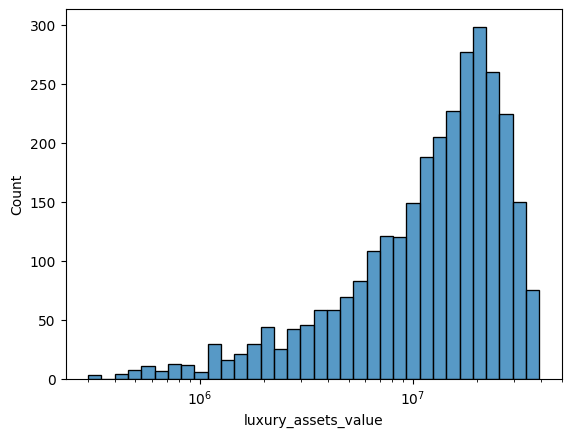

In [125]:
# Univariate distributions
sns.histplot(data=X_train["luxury_assets_value"], log_scale=True);

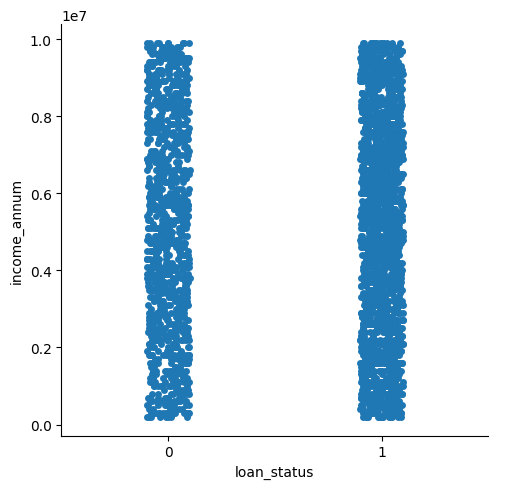

In [136]:
# Scatter between predictor and target
sns.catplot(y=X_train.income_annum, x=y_train)

In [106]:
# Missingness rates
X_train.isna().sum()

no_of_dependents            0
education                   0
self_employed               0
income_annum                0
loan_amount                 0
loan_term                   0
cibil_score                 0
residential_assets_value    0
commercial_assets_value     0
luxury_assets_value         0
bank_asset_value            0
dtype: int64

In [ ]:
# Save preprocessed dataset
df.to_csv("data/loan_data_processed.csv")

# Processing pipeline

In [128]:
# Pipeline for Numerical Features (Handle Missing -> Scale)
numerical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),  # critical for KNN to normalize distance
    ]
)

# Pipeline for categorical features (Handle Missing -> One-Hot Encode)
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        (
            "onehot",
            OneHotEncoder(handle_unknown="ignore", drop="if_binary"),
        ),  # Handles new categories in test set
    ]
)

# Combine transformers
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="passthrough",  # Keep any other columns if defined
)
#

# Model training and tuning

In [129]:
# Model 1: kNN with Tuning
print("\n--- Training KNN Model (with GridSearchCV) ---")

# Define the model pipeline
knn_pipe = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", KNeighborsClassifier())]
)

# Define the parameter grid for KNN tuning
knn_param_grid = {
    "classifier__n_neighbors": np.arange(1, 21, 2),  # Test odd K values from 3 to 19
    "classifier__weights": ["uniform", "distance"],
}

# Perform Grid Search Cross-Validation
knn_grid_search = GridSearchCV(
    knn_pipe, knn_param_grid, cv=5, scoring="f1", n_jobs=-1, verbose=2
)
knn_grid_search.fit(X_train, y_train)

best_knn = knn_grid_search.best_estimator_
knn_predictions = best_knn.predict(X_test)
print(f"Best KNN Parameters: {knn_grid_search.best_params_}")



--- Training KNN Model (with GridSearchCV) ---
Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END classifier__n_neighbors=1, classifier__weights=distance; total time=   0.0s
[CV] END classifier__n_neighbors=1, classifier__weights=distance; total time=   0.0s
[CV] END classifier__n_neighbors=1, classifier__weights=uniform; total time=   0.0s
[CV] END classifier__n_neighbors=1, classifier__weights=uniform; total time=   0.0s
[CV] END classifier__n_neighbors=1, classifier__weights=uniform; total time=   0.0s
[CV] END classifier__n_neighbors=1, classifier__weights=uniform; total time=   0.0s
[CV] END classifier__n_neighbors=1, classifier__weights=distance; total time=   0.0s
[CV] END classifier__n_neighbors=1, classifier__weights=uniform; total time=   0.0s
[CV] END classifier__n_neighbors=1, classifier__weights=distance; total time=   0.0s
[CV] END classifier__n_neighbors=3, classifier__weights=uniform; total time=   0.0s
[CV] END classifier__n_neighbors=3, classifier

In [130]:
# Model 2: Decision Tree with Tuning
print("\n--- Training Decision Tree Model (with GridSearchCV) ---")

# Define the model pipeline
dt_pipe = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", DecisionTreeClassifier(random_state=42)),
    ]
)

# Define the parameter grid for Decision Tree tuning
dt_param_grid = {
    "classifier__max_depth": np.arange(3, 11, 1),  # Test depths from 3 to 10
    "classifier__min_samples_split": [2, 5, 10],
    "classifier__criterion": ["gini", "entropy"],
}

# Perform Grid Search Cross-Validation
dt_grid_search = GridSearchCV(
    dt_pipe, dt_param_grid, cv=5, scoring="f1", n_jobs=-1, verbose=2
)
dt_grid_search.fit(X_train, y_train)

best_dt = dt_grid_search.best_estimator_
dt_predictions = best_dt.predict(X_test)
print(f"Best Decision Tree Parameters: {dt_grid_search.best_params_}")
#


--- Training Decision Tree Model (with GridSearchCV) ---
Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END classifier__criterion=gini, classifier__max_depth=3, classifier__min_samples_split=2; total time=   0.0s
[CV] END classifier__criterion=gini, classifier__max_depth=3, classifier__min_samples_split=2; total time=   0.0s
[CV] END classifier__criterion=gini, classifier__max_depth=3, classifier__min_samples_split=2; total time=   0.0s
[CV] END classifier__criterion=gini, classifier__max_depth=3, classifier__min_samples_split=2; total time=   0.0s
[CV] END classifier__criterion=gini, classifier__max_depth=3, classifier__min_samples_split=5; total time=   0.0s
[CV] END classifier__criterion=gini, classifier__max_depth=3, classifier__min_samples_split=5; total time=   0.0s
[CV] END classifier__criterion=gini, classifier__max_depth=3, classifier__min_samples_split=2; total time=   0.0s
[CV] END classifier__criterion=gini, classifier__max_depth=3, classifier__min_samp

# Model comparative evaluation

In [ ]:
def get_metrics(y_true, y_pred):
    """Calculates key classification metrics."""
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1-Score": f1_score(y_true, y_pred),
    }


# Calculate metrics for both models
knn_metrics = get_metrics(y_test, knn_predictions)
dt_metrics = get_metrics(y_test, dt_predictions)

# Create a comparison DataFrame
comparison_df = pd.DataFrame(
    {"KNN (Tuned)": knn_metrics, "Decision Tree (Tuned)": dt_metrics}
).T

print("\nModel Performance Comparison on Test Set")
print(comparison_df.to_markdown(floatfmt=".4f"))



Model Performance Comparison on Test Set
|                       |   Accuracy |   Precision |   Recall |   F1-Score |
|:----------------------|-----------:|------------:|---------:|-----------:|
| KNN (Tuned)           |     0.9149 |      0.9377 |   0.9247 |     0.9311 |
| Decision Tree (Tuned) |     0.9758 |      0.9910 |   0.9699 |     0.9803 |


# Feature importances (decision tree)

In [ ]:
# 1. Get feature names after preprocessing
ohe_feature_names = (
    best_dt.named_steps["preprocessor"]
    .named_transformers_["cat"]
    .named_steps["onehot"]
    .get_feature_names_out(categorical_features)
)
all_feature_names = numeric_features + ohe_feature_names.tolist()

# 2. Extract importance scores
dt_classifier = best_dt.named_steps["classifier"]
importances = dt_classifier.feature_importances_

# 3. Create and sort DataFrame
feature_importance_df = pd.DataFrame(
    {"Feature": all_feature_names, "Importance": importances}
).sort_values(by="Importance", ascending=False)

print("\nTop Feature Importances (from Decision Tree)")
print("-" * 50)
print(feature_importance_df.to_markdown(floatfmt=".4f"))


Top Feature Importances (from Decision Tree)
--------------------------------------------------
|    | Feature                  |   Importance |
|---:|:-------------------------|-------------:|
|  4 | cibil_score              |       0.7854 |
|  3 | loan_term                |       0.1288 |
|  2 | loan_amount              |       0.0380 |
|  1 | income_annum             |       0.0244 |
|  5 | residential_assets_value |       0.0103 |
|  6 | commercial_assets_value  |       0.0043 |
|  7 | luxury_assets_value      |       0.0032 |
|  8 | bank_asset_value         |       0.0031 |
|  9 | education_Not Graduate   |       0.0014 |
|  0 | no_of_dependents         |       0.0010 |
| 10 | self_employed_Yes        |       0.0000 |


# Findings

In loan approval, there are two types of critical errors:

- Type I Error (false positive) --> Cost of error = Financial Loss (approving a loan to a high-risk applicant who defaults. The bank loses money.)
- Type II error (false negative) --> Cost of error = Opportunity Cost (denying a loan to a low-risk applicant who would have repaid. The bank loses potential revenue.)

**Scenario 1: Risk Aversion**

If the bank is highly risk-averse and primarily concerned with minimizing financial losses from defaults, they should prioritize high Precision.
A model with high Precision ensures that when it approves a loan, the chances of that loan being good are very high.
The trade-off: The bank will inevitably deny some good applicants (more False Negatives), leading to lost business opportunities.

**Scenario 2: Market Expansion**

If the bank is in a market expansion phase and focused on maximizing the volume of loans while accepting slightly higher risk, they may prioritize high Recall.
A model with high Recall ensures that almost all good applicants are approved.
The trade-off: The bank will inevitably approve some high-risk applicants (more False Positives), leading to higher default rates.

In our case, we don't have information about the bank's preference so we take a balanced approach by using the F1-Score, i.e., the harmonic mean of Precision and Recall. The F1-Score provides a single, balanced measure of the model's performance on the positive class (Loan Approved), penalizing models that perform well on one metric while poorly on the other.

**Recommendation**   

From the two models explored, we would endorse the tuned decision tree as it clearly outperforms the k-NN classifier in all relevant metrics (precision, recall and F1 score) by a noticeable margin. At the same time, it is a more transparent and auditable model which is critical for loan decision-making applications.

The most influential factor for loan application outcome is the applicant's credit risk score. This finding shows that the bank should prioritize rigorous verification of the applicant's credit history and clearly define policy thresholds based on this factor.
The loan term has the second highest impact (by a margin from credit risk score) which indicates that the bank should carefully consider optimal loan durations to minimise default rates.
Other features like annual income and loan amount appear suspiciously insignificant, which casts a doubt on the quality and validity of the dataset.
